# [Tensorflow - Help Protect the Great Barrier Reef](https://www.kaggle.com/c/tensorflow-great-barrier-reef)
> Detect crown-of-thorns starfish in underwater image data

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/31703/logos/header.png?t=2021-10-29-00-30-04">

## 📒 Notebooks:
* Train: [Great-Barrier-Reef: YOLOv5 [train] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-train)
* Infer: [Great-Barrier-Reef: YOLOv5 [infer] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer)

# 🛠 Install Libraries

In [ ]:
# !pip install -qU wandb
# !add-apt-repository ppa:ubuntu-toolchain-r/test -y
# !apt-get update
# !apt-get upgrade libstdc++6 -y

# 📚 Import Libraries

In [ ]:
from itertools import groupby
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import pickle
import cv2
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
import glob

import shutil
import sys
sys.path.append('../input/tensorflow-great-barrier-reef')

from joblib import Parallel, delayed

from IPython.display import display, HTML

from matplotlib import animation, rc
rc('animation', html='jshtml')

# 📌 Key-Points
* One have to submit prediction using the provided **python time-series API**, which makes this competition different from previous Object Detection Competitions.
* Each prediction row needs to include all bounding boxes for the image. Submission is format seems also **COCO** which means `[x_min, y_min, width, height]`
* Copmetition metric `F2` tolerates some false positives(FP) in order to ensure very few starfish are missed. Which means tackling **false negatives(FN)** is more important than false positives(FP). 
$$F2 = 5 \cdot \frac{precision \cdot recall}{4\cdot precision + recall}$$

## Please Upvote if you find this Helpful

# ⭐ WandB
<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width=600>

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Some of the cool features of W&B:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.


# 📖 Meta Data
* `train_images/` - Folder containing training set photos of the form `video_{video_id}/{video_frame}.jpg`.

* `[train/test].csv` - Metadata for the images. As with other test files, most of the test metadata data is only available to your notebook upon submission. Just the first few rows available for download.

* `video_id` - ID number of the video the image was part of. The video ids are not meaningfully ordered.
* `video_frame` - The frame number of the image within the video. Expect to see occasional gaps in the frame number from when the diver surfaced.
* `sequence` - ID of a gap-free subset of a given video. The sequence ids are not meaningfully ordered.
* `sequence_frame` - The frame number within a given sequence.
* `image_id` - ID code for the image, in the format `{video_id}-{video_frame}`
* `annotations` - The bounding boxes of any starfish detections in a string format that can be evaluated directly with Python. Does not use the same format as the predictions you will submit. Not available in test.csv. A bounding box is described by the pixel coordinate `(x_min, y_min)` of its lower left corner within the image together with its `width` and `height` in pixels --> (COCO format).

In [ ]:
FOLD      = 4 # which fold to train
REMOVE_NOBBOX = True # remove images with no bbox
ROOT_DIR  = '/kaggle/input/tensorflow-great-barrier-reef/'
IMAGE_DIR = '/kaggle/images' # directory to save images
LABEL_DIR = '/kaggle/labels' # directory to save labels

## Create Directories

In [ ]:
!mkdir -p {IMAGE_DIR}
!mkdir -p {LABEL_DIR}

## Get Paths

In [ ]:
def get_path(row):
    row['old_image_path'] = f'{ROOT_DIR}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    row['image_path'] = f'{IMAGE_DIR}/video_{row.video_id}_{row.video_frame}.jpg'
    row['label_path'] = f'{LABEL_DIR}/video_{row.video_id}_{row.video_frame}.txt'
    return row

In [ ]:
# Train Data
df = pd.read_csv(f'{ROOT_DIR}/train.csv')
df = df.progress_apply(get_path, axis=1)
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
display(df.head(2))

## Number of BBoxes
> Nearly 80% images are without any bbox.

In [ ]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

# 🧹 Clean Data
* In this notebook, we use only **bboxed-images** (`~5k`). We can use all `~23K` images for train but most of them don't have any labels. So it would be easier to carry out experiments using only **bboxed images**.

In [ ]:
if REMOVE_NOBBOX:
    df = df.query("num_bbox>0")

# ✏️ Write Images
* We need to copy the Images to Current Directory(`/kaggle/working`) as `/kaggle/input` doesn't have **write access** which is needed for **YOLOv5**.
* We can make this process faster using **Joblib** which uses **Parallel** computing.

In [ ]:
def make_copy(path):
    data = path.split('/')
    filename = data[-1]
    video_id = data[-2]
    new_path = os.path.join(IMAGE_DIR,f'{video_id}_{filename}')
    shutil.copy(path, new_path)
    return

In [ ]:
image_paths = df.old_image_path.tolist()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(make_copy)(path) for path in tqdm(image_paths))

# 🔨 Helper

In [ ]:
def voc2yolo(image_height, image_width, bboxes):
    """
    voc  => [x1, y1, x2, y1]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]/ image_height
    
    w = bboxes[..., 2] - bboxes[..., 0]
    h = bboxes[..., 3] - bboxes[..., 1]
    
    bboxes[..., 0] = bboxes[..., 0] + w/2
    bboxes[..., 1] = bboxes[..., 1] + h/2
    bboxes[..., 2] = w
    bboxes[..., 3] = h
    
    return bboxes

def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes

def coco2yolo(image_height, image_width, bboxes):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normolizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes


def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def draw_bboxes(img, bboxes, classes, class_ids, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
     
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1-w, y1-h, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
            
    elif bbox_format == 'coco':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes:            
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                w  = int(round(bbox[2]))
                h  = int(round(bbox[3]))

                voc_bbox = (x1, y1, x1+w, y1+h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)

    elif bbox_format == 'voc_pascal':
        
        for idx in range(len(bboxes)):  
            
            bbox  = bboxes[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[cls_id] if type(colors) is list else colors
            
            if cls in show_classes: 
                x1 = int(round(bbox[0]))
                y1 = int(round(bbox[1]))
                x2 = int(round(bbox[2]))
                y2 = int(round(bbox[3]))
                voc_bbox = (x1, y1, x2, y2)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(cls_id),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row


# https://www.kaggle.com/diegoalejogm/great-barrier-reefs-eda-with-animations
def create_animation(ims):
    fig = plt.figure(figsize=(16, 12))
    plt.axis('off')
    im = plt.imshow(ims[0])

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1000//12)

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

## Create BBox

In [ ]:
df['bboxes'] = df.annotations.progress_apply(get_bbox)
df.head(2)

## Get Image-Size
> All Images have same dimension, [Width, Height] =  `[1280, 720]`

In [ ]:
df['width']  = 1280
df['height'] = 720
display(df.head(2))

# 🏷️ Create Labels
We need to export our labels to **YOLO** format, with one `*.txt` file per image (if no objects in image, no `*.txt` file is required). The *.txt file specifications are:

* One row per object
* Each row is class `[x_center, y_center, width, height]` format.
* Box coordinates must be in **normalized** `xywh` format (from `0 - 1`). If your boxes are in pixels, divide `x_center` and `width` by `image width`, and `y_center` and `height` by `image height`.
* Class numbers are **zero-indexed** (start from `0`).

> Competition bbox format is **COCO** hence `[x_min, y_min, width, height]`. So, we need to convert form **COCO** to **YOLO** format.


In [ ]:
cnt = 0
all_bboxes = []
for row_idx in tqdm(range(df.shape[0])):
    row = df.iloc[row_idx]
    image_height = row.height
    image_width  = row.width
    bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
    num_bbox     = len(bboxes_coco)
    names        = ['cots']*num_bbox
    labels       = [0]*num_bbox
    ## Create Annotation(YOLO)
    with open(row.label_path, 'w') as f:
        if num_bbox<1:
            annot = ''
            f.write(annot)
            cnt+=1
            continue
        bboxes_yolo  = coco2yolo(image_height, image_width, bboxes_coco)
        bboxes_yolo  = np.clip(bboxes_yolo, 0, 1)
        all_bboxes.extend(bboxes_yolo)
        for bbox_idx in range(len(bboxes_yolo)):
            annot = [str(labels[bbox_idx])]+ list(bboxes_yolo[bbox_idx].astype(str))+(['\n'] if num_bbox!=(bbox_idx+1) else [''])
            annot = ' '.join(annot)
            annot = annot.strip(' ')
            f.write(annot)
print('Missing:',cnt)

# 📁 Create Folds
> Number of samples aren't same in each fold which can create large variance in **Cross-Validation**.

In [ ]:
from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits = 5)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df, y = df.video_id.tolist(), groups=df.sequence)):
    df.loc[val_idx, 'fold'] = fold
display(df.fold.value_counts())

# 🍚 Dataset

In [ ]:
train_files = []
val_files   = []
train_df = df.query("fold!=@FOLD")
valid_df = df.query("fold==@FOLD")
train_files += list(train_df.image_path.unique())
val_files += list(valid_df.image_path.unique())
len(train_files), len(val_files)

# ⚙️ Configuration
The dataset config file requires
1. The dataset root directory path and relative paths to `train / val / test` image directories (or *.txt files with image paths)
2. The number of classes `nc` and 
3. A list of class `names`:`['cots']`

In [ ]:
import yaml

cwd = '/kaggle/working/'

with open(os.path.join( cwd , 'train.txt'), 'w') as f:
    for path in train_df.image_path.tolist():
        f.write(path+'\n')
            
with open(os.path.join(cwd , 'val.txt'), 'w') as f:
    for path in valid_df.image_path.tolist():
        f.write(path+'\n')

data = dict(
    path  = '/kaggle/working',
    train =  os.path.join( cwd , 'train.txt') ,
    val   =  os.path.join( cwd , 'val.txt' ),
    nc    = 1,
    names = ['cots'],
    )

with open(os.path.join( cwd , 'bgr.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( cwd , 'bgr.yaml'), 'r')
print('\nyaml:')
print(f.read())

# 📦 [YOLOv5](https://github.com/ultralytics/yolov5/)
<img src="https://github.com/ultralytics/yolov5/releases/download/v1.0/splash.jpg" width=800>

In [ ]:
%cd /kaggle/working
!rm -r /kaggle/working/yolov5
# !git clone https://github.com/ultralytics/yolov5 # clone
!cp -r /kaggle/input/yolov5-lib-ds /kaggle/working/yolov5
%cd yolov5
%pip install -qr requirements.txt  # install

from yolov5 import utils
display = utils.notebook_init()  # check

In [ ]:
#Custom Hyperparameters (Fine-Tuning)

import os
import yaml

cwd = '/kaggle/working/custom.yaml'

data = hyperparams = {'lr0': 0.01,
 'lrf': 0.1, 
 'momentum': 0.937,  
 'weight_decay': 0.0005,
 'warmup_epochs': 5.0, #3.0
 'warmup_momentum': 0.8, #0.8
 'warmup_bias_lr': 0.1, #0.1
 'box': 0.05,
 'cls': 0.5, #0.5
 'cls_pw': 1.0,
 'obj': 1.0,
 'obj_pw': 1.0,
 'iou_t': 0.2,
 'anchor_t': 4.0,
 'fl_gamma': 0.0,
 'hsv_h': 0.015,
 'hsv_s': 0.7,#0.7
 'hsv_v': 0.3,#0.3
 'degrees': 0.0,
 'translate': 0.1,
 'scale': 0.7, #0.5
 'shear': 0.0,
 'perspective': 0.0,
 'flipud': 0.0,
 'fliplr': 0.5,
 'mosaic': 0.5, #1.0 # 0.0 was better
 'mixup': 0.5, #0.0
 'copy_paste': 0.0}

with open(os.path.join( cwd ), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( cwd ), 'r')
print('\nyaml:')
print(f.read())



In [ ]:
# Weights & Biases  (optional)
import wandb
wandb.login(anonymous='must')

# 🚅 Training

In [ ]:
# Train YOLOv5s on COCO128 for 3 epochs
!python train.py --img 1280\
--hyp /kaggle/working/custom.yaml\
--batch 12\
--epochs 18\
--data /kaggle/working/bgr.yaml\
--weights yolov5m.pt --workers 0

# ✨ Overview
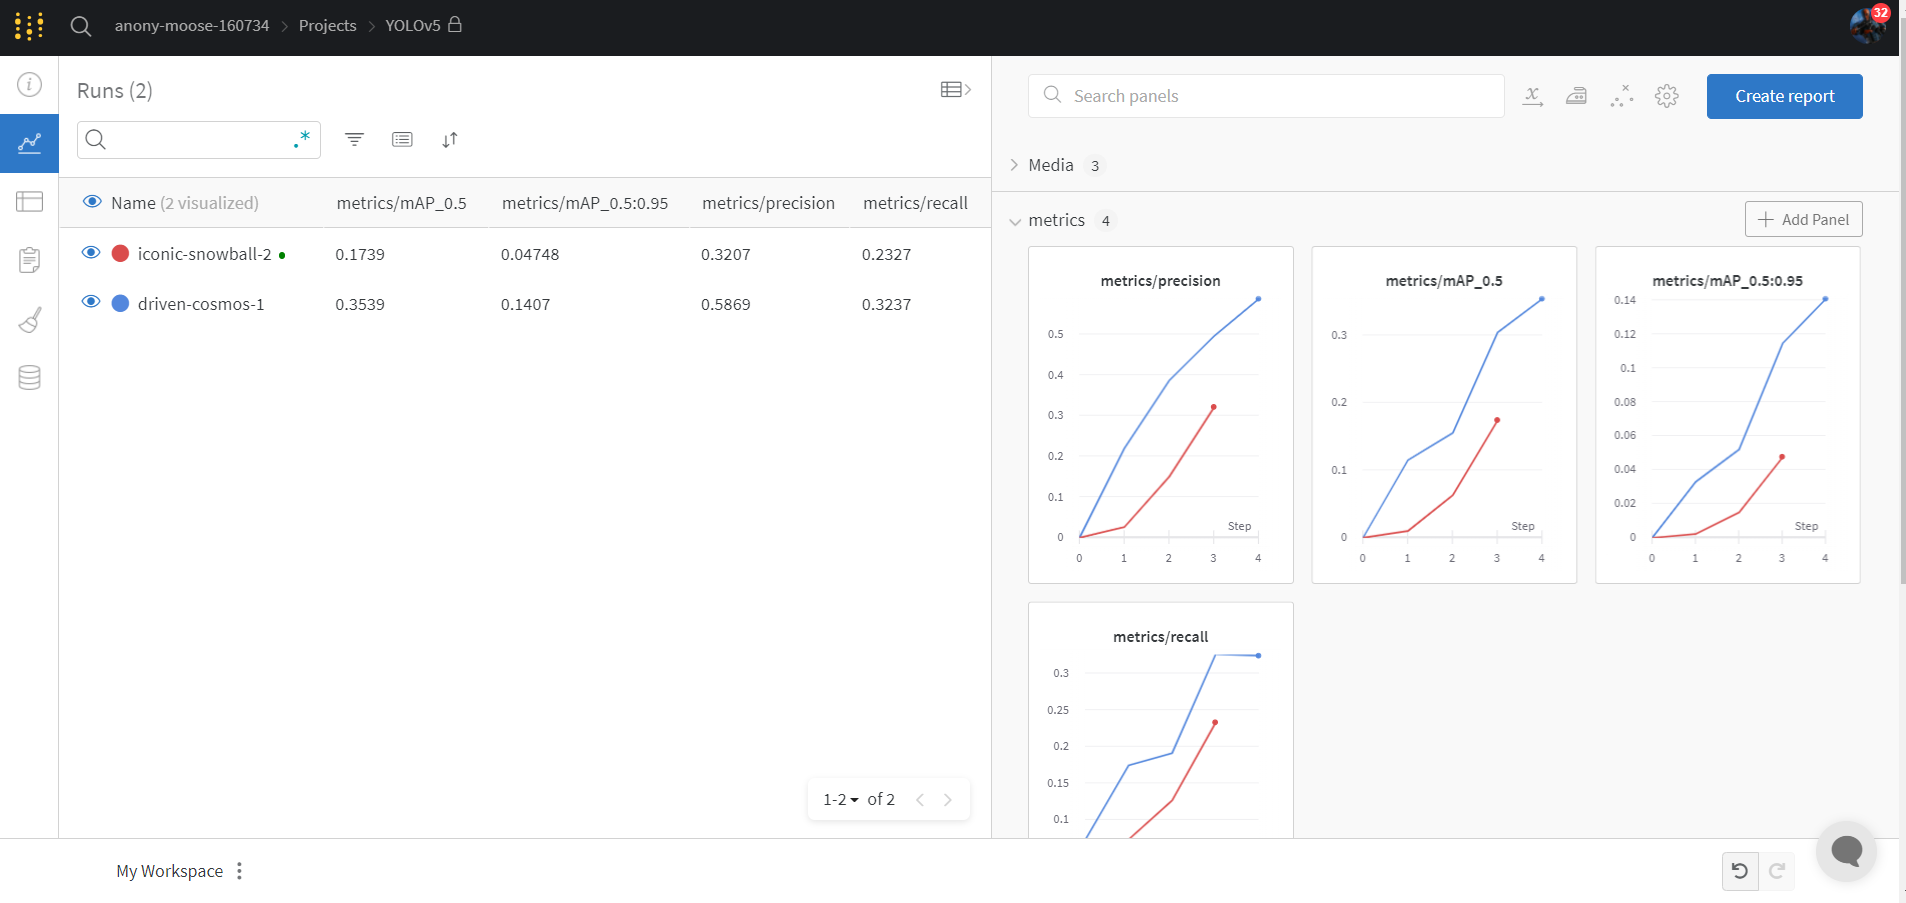

## Output Files

In [ ]:
!ls runs/train/exp

# 📈 Class Distribution

In [ ]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels_correlogram.jpg'));

In [ ]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/labels.jpg'));

# 🔭 Batch Image

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.imshow(plt.imread('runs/train/exp/train_batch0.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread('runs/train/exp/train_batch1.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread('runs/train/exp/train_batch2.jpg'))

## GT Vs Pred

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (2*9,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'runs/train/exp/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'runs/train/exp/val_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'runs/train/exp/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'runs/train/exp/val_batch{row}_pred.jpg', fontsize = 12)
plt.show()

# 🔍 Result

## Score Vs Epoch

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/results.png'));

## Confusion Matrix

In [ ]:
plt.figure(figsize=(12,10))
plt.axis('off')
plt.imshow(plt.imread('runs/train/exp/confusion_matrix.png'));

## Metrics

In [ ]:
for metric in ['F1', 'PR', 'P', 'R']:
    print(f'Metric: {metric}')
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(plt.imread(f'runs/train/exp/{metric}_curve.png'));
    plt.show()

## Please Upvote if you find this Helpful

# ✂️ Remove Files

In [ ]:
!rm -r {IMAGE_DIR}
!rm -r {LABEL_DIR}

<a href="ouput"> Download File </a>

<img src="https://www.pngall.com/wp-content/uploads/2018/04/Under-Construction-PNG-File.png">